In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function

sns.set()

## Adding variables

In [40]:
# read data
df = pd.read_excel("data/realised_schedule.xlsx")
df

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,VW,986,YYZ,320,J,CA,180,0.522222
36766,2022-02-08 19:30:00,LJ,579,YQU,319,J,CA,156,0.532051
36767,2022-02-08 19:40:00,LJ,506,YUL,319,J,CA,156,0.602564
36768,2022-02-08 19:05:00,CL,2708,DAN,73H,J,US,189,0.417989


Added variables: 
- Day og week
- 


Holiday (binary variable)

opmærksom: danmark og kastrup er det samme

In [38]:
# Add variables
# weekdays
df['weekday']=df['ScheduleTime'].dt.day_of_week
pd.get_dummies(df['weekday'])

# one-hot encoding
data = pd.get_dummies(df).drop(["FlightNumber", "SeatCapacity", "ScheduleTime"], axis = 1)

# Seperate X and y
y = data.LoadFactor.values
X = data.drop("LoadFactor", axis = 1).values

In [10]:
cal = calendar()
holidays = cal.holidays(start = df.ScheduleTime.iloc[0], end = df.ScheduleTime.iloc[-1])
print(holidays)
# df.apply({'ScheduleTime': lambda x: x.isin())})

df.ScheduleTime.isin(holidays).sum()

# np.array(holidays, dtype = str)

DatetimeIndex(['2021-01-18', '2021-02-15', '2021-05-31', '2021-06-18',
               '2021-07-05', '2021-09-06', '2021-10-11', '2021-11-11',
               '2021-11-25', '2021-12-24', '2021-12-31', '2022-01-17'],
              dtype='datetime64[ns]', freq=None)


0

## Data Analysis

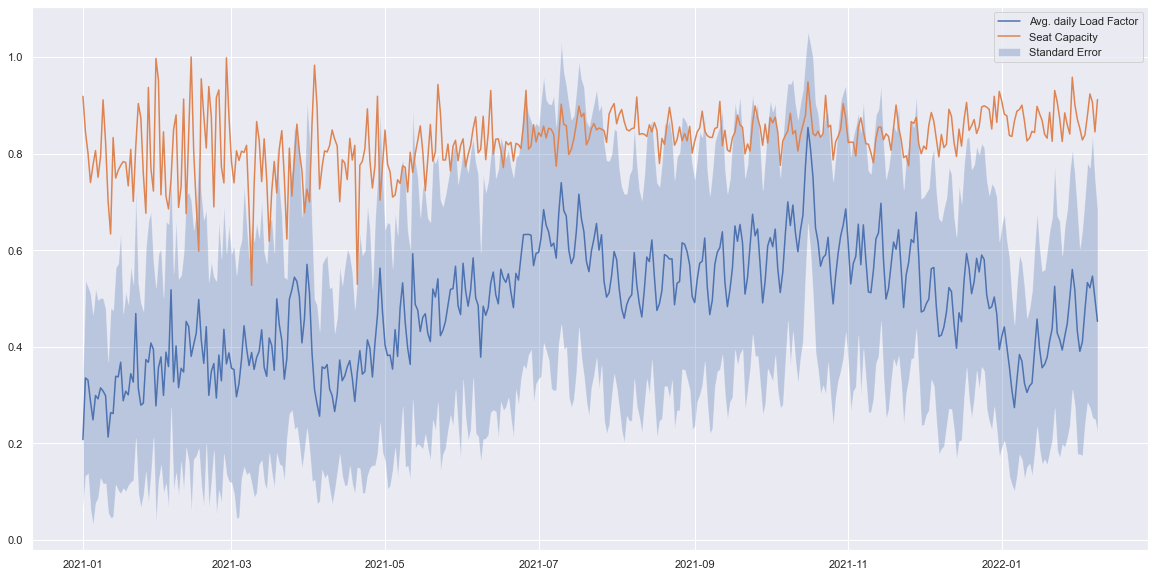

In [11]:
fig,ax = plt.subplots(figsize = (20,10))
df2 = df.set_index("ScheduleTime")
mean = df2.LoadFactor.resample('1d').mean()
mean2 = df2.SeatCapacity.resample('1d').mean() / df2.SeatCapacity.resample('1d').mean().max()
std  = df2.LoadFactor.resample('1d').std(ddof = 1)

ax.plot(mean, label = 'Avg. daily Load Factor')
ax.plot(mean2, label = 'Seat Capacity')
ax.fill_between(std.index, mean - std, mean + std, alpha = 0.3, label = 'Standard Error');
ax.legend()
plt.show()



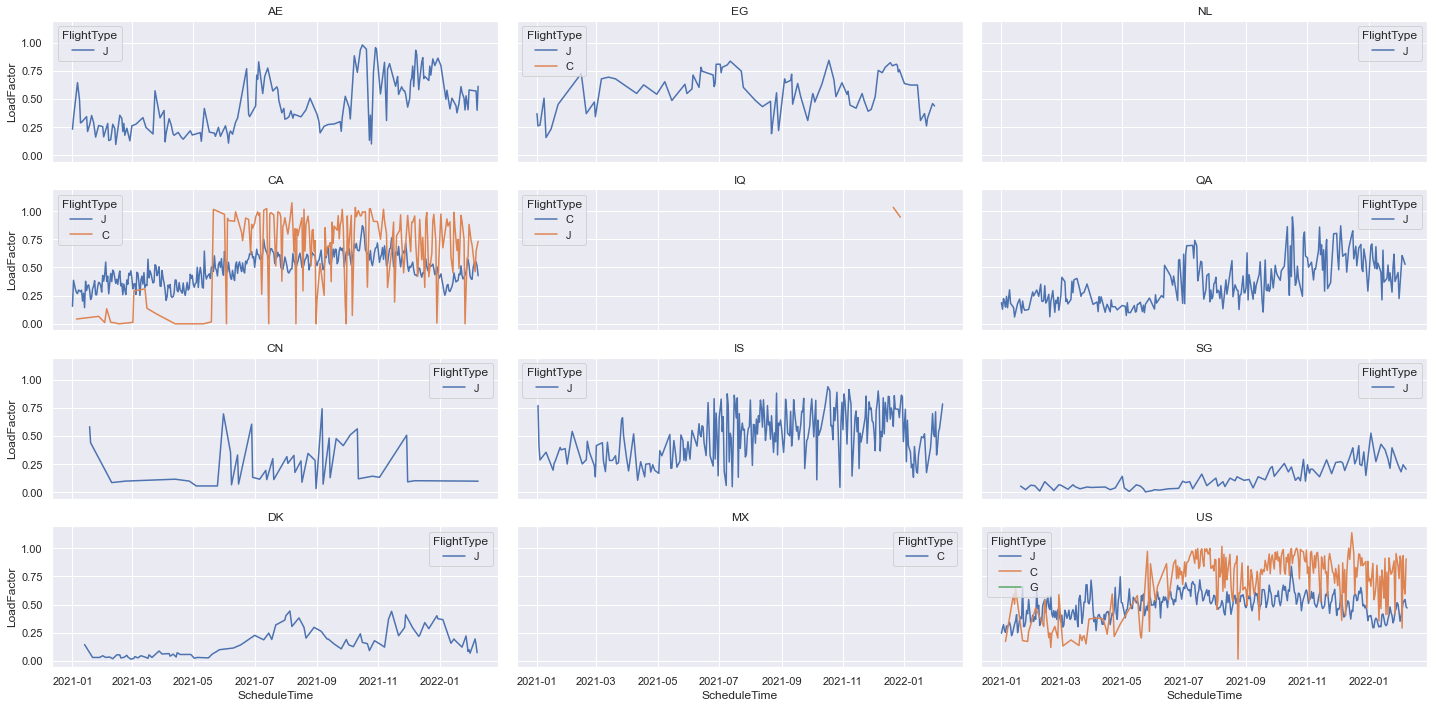

In [12]:
df2 = df.copy()
df2.ScheduleTime = pd.to_datetime(df.ScheduleTime).dt.date
df2
means = df2.groupby(["Sector", "ScheduleTime", 'FlightType']).aggregate({'LoadFactor':'mean'}).reset_index()

dests = means.Sector.unique()

fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    sns.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', hue = 'FlightType', legend = True, ax = a, ls = '-')
    a.set_title(dests[i])

fig.tight_layout()


In [ ]:
fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    sns.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', hue = 'Destination', legend = False, ax = a, ls = '-.')
    a.set_title(dests[i])

fig.tight_layout()

## Models

In [ ]:


def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


K = 10
M = 20
lambdas = np.logspace(-4, 1, M)
MSE = np.zeros((K, M))

kf = KFold(n_splits=K, shuffle = True)


mse_train = np.zeros((K, M))
mse_test  = np.zeros((K,M))
betas     = np.zeros((K,M,X.shape[-1]))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i} out of {K} folds")
    X_train, X_test = X[train_index, :], X[test_index, :],
    y_train, y_test = y[train_index], y[test_index]
    

    for j, lambda_ in enumerate(lambdas):
        model = linear_model.Ridge(alpha = lambda_)
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)

        err_train = pow(y_train - y_hat_train, 2).mean()
        err_test = pow(y_test - y_hat_test, 2).mean()

        mse_train[i,j] = err_train
        mse_test[i,j] = err_test

        beta = model.coef_.ravel()

        betas[i,j,:] = beta

    

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))

ax[0].plot(lambdas, mse_train.mean(0), label = 'Training Error')
ax[0].plot(lambdas, mse_test.mean(0),  label = 'Test error')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(lambdas, betas.mean(0))
ax[1].legend()
ax[1].set_xscale('log')

In [ ]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


K = 5
M = 10
lambdas = np.logspace(-10, 1, M)
MSE = np.zeros((K, M))

kf = KFold(n_splits=K, shuffle = True)


mse_train = np.zeros((K, M))
mse_test  = np.zeros((K,M))
betas     = np.zeros((K,M,X.shape[-1]))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i} out of {K} folds")
    X_train, X_test = X[train_index, :], X[test_index, :],
    y_train, y_test = y[train_index], y[test_index]
    

    for j, lambda_ in enumerate(lambdas):
        model = linear_model.Lasso(alpha = lambda_)
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)

        err_train = pow(y_train - y_hat_train, 2).mean()
        err_test = pow(y_test - y_hat_test, 2).mean()

        mse_train[i,j] = err_train
        mse_test[i,j] = err_test

        beta = model.coef_.ravel()

        betas[i,j,:] = beta

    

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))

ax[0].plot(lambdas, mse_train.mean(0), label = 'Training Error')
ax[0].plot(lambdas, mse_test.mean(0),  label = 'Test error')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(lambdas, betas.mean(0))
ax[1].legend()
ax[1].set_xscale('log')